# IMDB & Embedding

Sentiment analysis on the IMDB data base with pretrained embeddings, RNN, LSTM cell, etc.

# Load libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras 
from tensorflow.keras import layers
import tensorflow_hub as hub
from collections import Counter

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)

# Test GPU

In [2]:
print(f"TensorFlow Version: {tf.__version__}")

print('\nDevice name:')
print(tf.test.gpu_device_name())

print('\nList physical devices:')
print(tf.config.list_physical_devices('GPU'))

# Returns whether TensorFlow was built with 
# GPU (CUDA or ROCm) support
print('\nwith GPU (CUDA or ROCm) support?')
print(tf.test.is_built_with_gpu_support())

# Returns whether TensorFlow was built with 
# CUDA (GPU) support
print('\nwith CUDA (GPU) support?')
print(tf.test.is_built_with_cuda())


TensorFlow Version: 2.7.0

Device name:
/device:GPU:0

List physical devices:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

with GPU (CUDA or ROCm) support?
True

with CUDA (GPU) support?
True


# My functions

In [3]:
def plot_loss_acc(history_dict):
    # Function to plot losses and accuracies

    loss_values = history_dict["loss"]
    val_loss_values = history_dict["val_loss"]

    acc = history_dict["accuracy"]
    val_acc = history_dict["val_accuracy"]

    epochs = range(1, len(loss_values) + 1)
    f, axes = plt.subplots(1, 2, figsize=(15, 5))
    # Loss
    axes[0].plot(epochs, loss_values, "bo-", label="Training loss")
    axes[0].plot(epochs, val_loss_values, "rv-", label="Validation loss")
    axes[0].set_title("Model loss")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    # Accuracy
    axes[1].plot(epochs, acc, "bo-", label="Training acc")
    axes[1].plot(epochs, val_acc, "rv-", label="Validation acc")
    axes[1].set_title("Model accuracy")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    #
    plt.show()

# Load data

In [4]:
# "as_supervised=True" means that the returned tf.data.Dataset will have a 2-tuple
# structure (input, label). If "False" (default), the returned dataset will have a
# dictionary with all the features.
#
# "with_info=True" means that the tfds.load will return the tuple
# (tf.data.Dataset, tfds.core.DatasetInfo), where the latter contains the info
# associated with the builder.
datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)

# Explore data sctructure

In [5]:
print(info)

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset.
    This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_path='C:\\Users\\danie\\tensorflow_datasets\\imdb_reviews\\plain_text\\1.0.0',
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=25000, num_shards=1>,
        'train':

In [6]:
print(info.splits['train'])
print(f"num examples = {info.splits['train'].num_examples}")
print("="*50)
print(info.splits['test'])
print(f"num examples = {info.splits['test'].num_examples}")


<SplitInfo num_examples=25000, num_shards=1>
num examples = 25000
<SplitInfo num_examples=25000, num_shards=1>
num examples = 25000


In [7]:
print(datasets)

{'train': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>, 'test': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>, 'unsupervised': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>}


In [8]:
print(datasets['train'])

<PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>


In [9]:
for x, y in datasets["train"].batch(2).take(1):
    print(x)
    print(y)

tf.Tensor(
[b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
 b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot de

In [10]:
for x, y in datasets["train"].batch(2).take(1):
    for review, label in zip(x, y):
        print(review)
        print(label)
        print("="*50)

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on t

In [11]:
for x, y in datasets["train"].batch(2).take(1):
    for review, label in zip(x, y):
        print(review.numpy())
        print(f"Label: {label.numpy()}")
        print("="*50)

b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
Label: 0
b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot develo

In [12]:
for x, y in datasets["train"].batch(2).take(1):
    for review, label in zip(x, y):
        print(review.numpy().decode("utf-8"))
        print(f"Label: {label.numpy()}")
        print("="*50)

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
Label: 0
I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development

In [13]:
for reviews, _ in datasets['train'].batch(2).take(1):
    for review in reviews:
        print(review.numpy())
        review = tf.strings.substr(review, 0, 100)
        print(review.numpy())    
        print('='*50)

b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. "
b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just ea

In [14]:
for reviews, _ in datasets['train'].batch(2).take(1):
    for review in reviews:
        print(review.numpy())
        review = tf.strings.regex_replace(review, b"[^a-zA-Z']", b" ")
        print(review.numpy())    
        print('='*50)

b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
b"This was an absolutely terrible movie  Don't be lured in by Christopher Walken or Michael Ironside  Both are great actors  but this must simply be their worst role in history  Even their great acting could not redeem this movie's ridiculous storyline  This movie is an early nineties U

In [15]:
for reviews, _ in datasets['train'].batch(2).take(1):
    for review in reviews:
        print(review.numpy())
        review = tf.strings.split(review)
        print(review.numpy())    
        print('='*50)

b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
[b'This' b'was' b'an' b'absolutely' b'terrible' b'movie.' b"Don't" b'be'
 b'lured' b'in' b'by' b'Christopher' b'Walken' b'or' b'Michael'
 b'Ironside.' b'Both' b'are' b'great' b'actors,' b'but' b'this' b'must'
 b'simply' b'be' b'their' b'worst' b'role' b'in' b'history.' b'Even'
 b'their'

In [16]:
for reviews, _ in datasets['train'].batch(2).take(1):
    # subset 30 characters
    reviews = tf.strings.substr(reviews, 0, 30)
    print(reviews.numpy())
    print('='*70)
    reviews = tf.strings.regex_replace(reviews, b"[^a-zA-Z']", b" ")
    # Since we selected only 30 characters, the sentences have different
    # number of words (based on the length of the words)
    reviews = tf.strings.split(reviews)
    print(reviews)
    print('*'*70)
    print(reviews[0])
    print(reviews[1])
    print('+'*70)
    # With default_value="<pad>", the tensors have the same length and the
    # value "<pad>" is added to the ternsor shorter than the longest one
    reviews = reviews.to_tensor(default_value="<pad>")
    print(reviews)
    

[b'This was an absolutely terribl' b'I have been known to fall asle']
<tf.RaggedTensor [[b'This', b'was', b'an', b'absolutely', b'terribl'], [b'I', b'have', b'been', b'known', b'to', b'fall', b'asle']]>
**********************************************************************
tf.Tensor([b'This' b'was' b'an' b'absolutely' b'terribl'], shape=(5,), dtype=string)
tf.Tensor([b'I' b'have' b'been' b'known' b'to' b'fall' b'asle'], shape=(7,), dtype=string)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
tf.Tensor(
[[b'This' b'was' b'an' b'absolutely' b'terribl' b'<pad>' b'<pad>']
 [b'I' b'have' b'been' b'known' b'to' b'fall' b'asle']], shape=(2, 7), dtype=string)


# Preprocessing

Tensorflow represents strings as byte array.
So, we use the b before the string (i.e., `b" "`) because we need the bytes type and not a str type.

In [17]:
def preprocessing(X_batch, y_batch):
    # subset the sentence (only characters from 0 to 300)
    X_batch = tf.strings.substr(X_batch, 0, 300)
    # replace "<br />" tags with space
    X_batch = tf.strings.regex_replace(X_batch, b"<br\\s*/?>", b" ")
    # replace non-letter and apostrophe with space
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
    # split the sentences by space (NOTE: "split" returns a ragged tensor)
    X_batch = tf.strings.split(X_batch)
    # convert the ragged tensors into dense tensors.
    # (NOTE: default_value="<pad>" makes sure that all tensors have the same length;
    # the value "<pad>" is added to ternsors shorter than the longest one)
    X_batch = X_batch.to_tensor(default_value=b"<pad>")
    return X_batch, y_batch

In [18]:
for X_tmp, y_tmp in datasets['train'].batch(2).take(1):
    X_tmp, y_tmp = preprocessing(X_tmp, y_tmp)

print(X_tmp)

tf.Tensor(
[[b'This' b'was' b'an' b'absolutely' b'terrible' b'movie' b"Don't" b'be'
  b'lured' b'in' b'by' b'Christopher' b'Walken' b'or' b'Michael'
  b'Ironside' b'Both' b'are' b'great' b'actors' b'but' b'this' b'must'
  b'simply' b'be' b'their' b'worst' b'role' b'in' b'history' b'Even'
  b'their' b'great' b'acting' b'could' b'not' b'redeem' b'this'
  b"movie's" b'ridiculous' b'storyline' b'This' b'movie' b'is' b'an'
  b'early' b'nineties' b'US' b'propaganda' b'pi' b'<pad>' b'<pad>'
  b'<pad>']
 [b'I' b'have' b'been' b'known' b'to' b'fall' b'asleep' b'during'
  b'films' b'but' b'this' b'is' b'usually' b'due' b'to' b'a'
  b'combination' b'of' b'things' b'including' b'really' b'tired' b'being'
  b'warm' b'and' b'comfortable' b'on' b'the' b'sette' b'and' b'having'
  b'just' b'eaten' b'a' b'lot' b'However' b'on' b'this' b'occasion' b'I'
  b'fell' b'asleep' b'because' b'the' b'film' b'was' b'rubbish' b'The'
  b'plot' b'development' b'was' b'constant' b'Cons']], shape=(2, 53), dtype=string)

# Construct vocabolary

The procedure to construct a `vocabolary`:

1. go through the whole training set once
2. apply `preprocessing()`
3. use a `Counter` object to count the number of occurences of each word

In [19]:
# "Counter" is a dict subclass for counting hashable objects.
# An object is hashable if:
# 1) it has a hash value which NEVER changes during its lifetime
# 2) it can be compared to other objects
vocabulary_tmp = Counter()

In [20]:
print(vocabulary_tmp)

Counter()


In [21]:
for X, y in datasets["train"].batch(2).take(1).map(preprocessing):
    for review in X:
        print(review)
        print('='*70)
        vocabulary_tmp.update(list(review.numpy()))

tf.Tensor(
[b'This' b'was' b'an' b'absolutely' b'terrible' b'movie' b"Don't" b'be'
 b'lured' b'in' b'by' b'Christopher' b'Walken' b'or' b'Michael'
 b'Ironside' b'Both' b'are' b'great' b'actors' b'but' b'this' b'must'
 b'simply' b'be' b'their' b'worst' b'role' b'in' b'history' b'Even'
 b'their' b'great' b'acting' b'could' b'not' b'redeem' b'this' b"movie's"
 b'ridiculous' b'storyline' b'This' b'movie' b'is' b'an' b'early'
 b'nineties' b'US' b'propaganda' b'pi' b'<pad>' b'<pad>' b'<pad>'], shape=(53,), dtype=string)
tf.Tensor(
[b'I' b'have' b'been' b'known' b'to' b'fall' b'asleep' b'during' b'films'
 b'but' b'this' b'is' b'usually' b'due' b'to' b'a' b'combination' b'of'
 b'things' b'including' b'really' b'tired' b'being' b'warm' b'and'
 b'comfortable' b'on' b'the' b'sette' b'and' b'having' b'just' b'eaten'
 b'a' b'lot' b'However' b'on' b'this' b'occasion' b'I' b'fell' b'asleep'
 b'because' b'the' b'film' b'was' b'rubbish' b'The' b'plot' b'development'
 b'was' b'constant' b'Cons'], shape=

In [22]:
print(f"length: {len(vocabulary_tmp)}")
print(f"\nvocabulary_tmp:\n{vocabulary_tmp}")
print(f"\nmost common:\n{vocabulary_tmp.most_common()[:5]}")

length: 83

vocabulary_tmp:
Counter({b'this': 4, b'was': 3, b'<pad>': 3, b'This': 2, b'an': 2, b'movie': 2, b'be': 2, b'in': 2, b'great': 2, b'but': 2, b'their': 2, b'is': 2, b'I': 2, b'to': 2, b'asleep': 2, b'a': 2, b'and': 2, b'on': 2, b'the': 2, b'absolutely': 1, b'terrible': 1, b"Don't": 1, b'lured': 1, b'by': 1, b'Christopher': 1, b'Walken': 1, b'or': 1, b'Michael': 1, b'Ironside': 1, b'Both': 1, b'are': 1, b'actors': 1, b'must': 1, b'simply': 1, b'worst': 1, b'role': 1, b'history': 1, b'Even': 1, b'acting': 1, b'could': 1, b'not': 1, b'redeem': 1, b"movie's": 1, b'ridiculous': 1, b'storyline': 1, b'early': 1, b'nineties': 1, b'US': 1, b'propaganda': 1, b'pi': 1, b'have': 1, b'been': 1, b'known': 1, b'fall': 1, b'during': 1, b'films': 1, b'usually': 1, b'due': 1, b'combination': 1, b'of': 1, b'things': 1, b'including': 1, b'really': 1, b'tired': 1, b'being': 1, b'warm': 1, b'comfortable': 1, b'sette': 1, b'having': 1, b'just': 1, b'eaten': 1, b'lot': 1, b'However': 1, b'occasion':

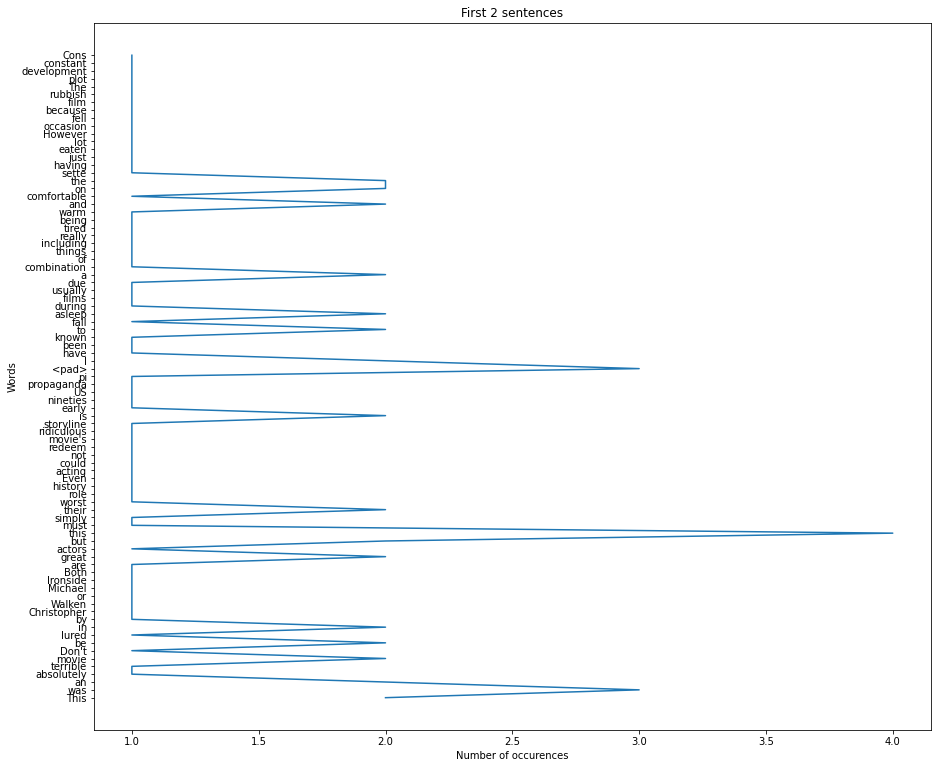

In [23]:
plt.figure(figsize=(15, 13))
plt.plot( vocabulary_tmp.values(), vocabulary_tmp.keys())
plt.title('First 2 sentences')
plt.ylabel('Words')
plt.xlabel('Number of occurences')
plt.show()

In [24]:
# "Counter" is a dict subclass for counting hashable objects.
# An object is hashable if:
# 1) it has a hash value which NEVER changes during its lifetime
# 2) it can be compared to other objects
vocabulary = Counter()

In [25]:
for X, y in datasets["train"].batch(32).map(preprocessing):
    for review in X:
        vocabulary.update(list(review.numpy()))


In [26]:
# 10 most common words in the data set
vocabulary.most_common()[:10]

[(b'<pad>', 214309),
 (b'the', 61137),
 (b'a', 38564),
 (b'of', 33983),
 (b'and', 33431),
 (b'to', 27707),
 (b'I', 27019),
 (b'is', 25719),
 (b'in', 18966),
 (b'this', 18490)]

In [27]:
len(vocabulary)

53893

In [28]:
# We will only use the 10000 most common words in the vocabolary
vocab_size = 10000
vocabulary_subset = [word for word, count in vocabulary.most_common()[:vocab_size]]

In [29]:
print(len(vocabulary_subset))
print(type(vocabulary_subset))

10000
<class 'list'>


In [30]:
print(vocabulary_subset[:10])

[b'<pad>', b'the', b'a', b'of', b'and', b'to', b'I', b'is', b'in', b'this']


# Lookup table

We use a *lookup table* to replace each word with its index in `vocabulary_subset`
(this gives the word's **ID**)

In [31]:
for index, word in enumerate(vocabulary_subset[:10]):
    print(index, " -- ", word)

0  --  b'<pad>'
1  --  b'the'
2  --  b'a'
3  --  b'of'
4  --  b'and'
5  --  b'to'
6  --  b'I'
7  --  b'is'
8  --  b'in'
9  --  b'this'


In [32]:
# this is the list of all possible words
words_vocab_subset = tf.constant(vocabulary_subset)
print(f"type = {type(words_vocab_subset)}")
print(f"\nFirst 10 =\n{words_vocab_subset[:10]}")

type = <class 'tensorflow.python.framework.ops.EagerTensor'>

First 10 =
[b'<pad>' b'the' b'a' b'of' b'and' b'to' b'I' b'is' b'in' b'this']


In [33]:
# This is a tensor with the indices of the words
word_ids = tf.range(len(vocabulary_subset), dtype=tf.int64)
print(f"type = {type(word_ids)}")
print(f"\nFirst 10 =\n{word_ids[:10]}")

type = <class 'tensorflow.python.framework.ops.EagerTensor'>

First 10 =
[0 1 2 3 4 5 6 7 8 9]


In [34]:
# This is an initializer for the lookup table
table_init = tf.lookup.KeyValueTensorInitializer(words_vocab_subset, word_ids)
print(f"type = {type(table_init)}")

type = <class 'tensorflow.python.ops.lookup_ops.KeyValueTensorInitializer'>


In the following cell we set the number of out-of-vocabulary buckets
and create a lookup table.

The number of out-of-vocabulary buckets is 1000 (`num_oov_buckets = 1000`),
which means that when the script look up for a word that does NOT exist 
in the vocabulary, then the lookup table will compute a HASH of this new
word and use it to assign the unknown word to one of the oov buckets.
The oov indices start after the known words (here: `vocab_size = 10000`,
that is from 0 to 9999). So, here the oov indices start at 10000 and end at 10999.
If there are not enough oov buckets (i.e., there are more unknown words than oov
buckets) there are "collisions", that is different words will end up in the same
oov bucket, and thus the NN will not be able to distinguish them.

In [35]:
# This creates the lookup table.
num_oov_buckets = 1000
lookup_table = tf.lookup.StaticVocabularyTable(table_init, num_oov_buckets)
print(f"type = {type(lookup_table)}")
print(f"\nLookup some words =\n{lookup_table.lookup(tf.constant([b'<pad>', b'the', b'an', b'book']))}")
print(f"\nLookup a sentence as list =\n{lookup_table.lookup(tf.constant([b'This', 'is', 'a', 'sentence']))}")
print(f"\nLookup a sentence splitted =\n{lookup_table.lookup(tf.constant([b'This is a sentence'.split()]))}")


type = <class 'tensorflow.python.ops.lookup_ops.StaticVocabularyTable'>

Lookup some words =
[  0   1  28 248]

Lookup a sentence as list =
[  22    7    2 5684]

Lookup a sentence splitted =
[[  22    7    2 5684]]


In [36]:
# An unknown word is mapped to values above 10000
print(lookup_table.lookup(tf.constant([b'wurst is a German word'.split()])))

tf.Tensor([[10106     7     2  1072   634]], shape=(1, 5), dtype=int64)


In [37]:
lookup_table.lookup(tf.constant([b"This movie was faaaaaantastic".split()]))

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[   22,    12,    11, 10053]], dtype=int64)>

# Prepare train and val data

In [38]:
# Function to encode the words using the lookup table create above
def encode_words(X_batch, y_batch):
    return lookup_table.lookup(X_batch), y_batch

In [39]:
print(f"num examples = {info.splits['train'].num_examples}")
print(f"len(datasets['train']) = {len(datasets['train'])}")

num examples = 25000
len(datasets['train']) = 25000


In [40]:
# Check how shuffle works
for i in datasets["train"].take(3):
    print(f"sentences:\n{i[0]}")
    print(f"labels: {i[1]}")
    print("="*70)

len_train = len(datasets['train'])
a1 = datasets["train"].shuffle(buffer_size=len_train, seed=42)

print("\nSHUFFLE", "+"*70, "\n")

for i in a1.take(3):
    print(f"sentences:\n{i[0]}")
    print(f"labels: {i[1]}")
    print("="*70)

sentences:
b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
labels: 0
sentences:
b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was r

Split `datasets["train"]` into train and validation

In [41]:
size_train_set = int(len(datasets["train"]) * 0.8)

print(f"Size full set:  {len(datasets['train'])}")
print(f"Size train set: {size_train_set}")
print(f"Size val set:    {len(datasets['train']) - size_train_set}")

train_set = datasets["train"].take(int(20000))
val_set = datasets["train"].skip(int(20000))

print(f"\nSize train_set: {len(train_set)}")
print(f"Size val_set:    {len(val_set)}")

Size full set:  25000
Size train set: 20000
Size val set:    5000

Size train_set: 20000
Size val_set:    5000


In [42]:
# Create train set
# len_train = len(train_set)
#train_set = train_set.shuffle(buffer_size=len_train, seed=42)
train_set = train_set.batch(32).map(preprocessing)
train_set = train_set.map(encode_words).prefetch(1)

In [43]:
# Create validation set
# len_val = len(val_set)
# val_set = val_set.shuffle(buffer_size=len_val, seed=42)
val_set = val_set.batch(32).map(preprocessing)
val_set = val_set.map(encode_words).prefetch(1)

In [44]:
# Create the train_val set
#len_train = len(datasets['train'])
#train_val_set = datasets["train"].shuffle(buffer_size=len_train, seed=42)
#train_val_set = train_val_set.batch(32).map(preprocessing)
## train_val_set = datasets["train"].batch(32).map(preprocessing)
#train_val_set = train_val_set.map(encode_words).prefetch(1)

In [45]:
for i in train_set.take(3):
    print(f"sentences:\n{i[0]}")
    print(f"\nlabels:\n{i[1]}")
    print(f"\nbatch len:\n{len(i[0])}")
    print("="*70, "\n")
    

sentences:
[[  22   11   28 ...    0    0    0]
 [   6   21   70 ...    0    0    0]
 [4099 6881    1 ...    0    0    0]
 ...
 [  22   12  118 ...  331 1047    0]
 [1757 4101  451 ...    0    0    0]
 [3365 4392    6 ...    0    0    0]]

labels:
[0 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0]

batch len:
32

sentences:
[[   14 10911   206 ...     0     0     0]
 [    6    11 10507 ...    28     0     0]
 [  122  1011     6 ...     0     0     0]
 ...
 [   74   592     4 ...     0     0     0]
 [ 8386    36     9 ...     0     0     0]
 [    6   151   469 ...     0     0     0]]

labels:
[0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1]

batch len:
32

sentences:
[[ 3191 10054  9096 ...     0     0     0]
 [ 1086   440 10370 ...     0     0     0]
 [  168 10352   981 ...     0     0     0]
 ...
 [    9     7    23 ...     0     0     0]
 [ 2174    27  1028 ...     0     0     0]
 [    6   666   140 ...     0     0     0]]

labels:
[1 1 0 0 1 0 0 0 1 0

sentences:
[   22    11    28   337   302    12   628    25 10501     8    31  1296
  3455    45   451 10966  1822    26    68   147    20     9   202   389
    25    89   143   286     8   443   431    89    68    87    99    24
  6479     9  1568   623   584    22    12     7    28   348  5108  1026
  2119 10325     0     0     0     0     0     0     0     0     0     0]

sentence len: 60


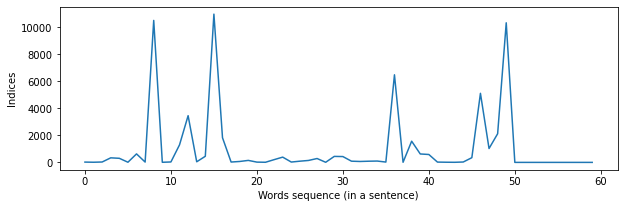

In [46]:
plt.figure(figsize=(10, 3))
this_sentence=0 # take the first sentence in the batch
for review, label in train_set.take(1):
    ax = sns.lineplot(review[this_sentence])
    ax.set(xlabel='Words sequence (in a sentence)', ylabel='Indices')
    print(f"sentences:\n{review[this_sentence]}")
    print(f"\nsentence len: {len(review[this_sentence])}")
plt.show()

In [47]:
for i in val_set.take(3):
    print(f"sentences:\n{i[0]}")
    print(f"\nlabels:\n{i[1]}")
    print(f"\nbatch len:\n{len(i[0])}")
    print("="*70, "\n")

sentences:
[[ 1218   160     5 ...     0     0     0]
 [  274    11  1748 ...     0     0     0]
 [    6   264 10627 ...     0     0     0]
 ...
 [  481  1227   102 ...     0     0     0]
 [ 1396  1308     7 ...   140    10   504]
 [ 5661  4712    14 ...     0     0     0]]

labels:
[0 1 1 1 0 0 0 1 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 1 0 0 1 0]

batch len:
32

sentences:
[[  293 10093     1 ...     0     0     0]
 [10180  2729   527 ...     0     0     0]
 [ 1211 10420   522 ...     0     0     0]
 ...
 [ 1086  6140     4 ...     0     0     0]
 [  856  4670 10952 ...     0     0     0]
 [  550     1   414 ...     0     0     0]]

labels:
[0 0 1 1 1 1 1 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1]

batch len:
32

sentences:
[[    6    21    60 ...     0     0     0]
 [ 1047   140    44 ...     0     0     0]
 [   97     2  7760 ...     0     0     0]
 ...
 [  240   232   227 ...   131 10235     0]
 [   14  3285     3 ...     0     0     0]
 [    6   172    16 ...     0     0  

# Model 1: embedding + GRU

**Masking**: since we already know that the padding token (`<pad>`)should be ignored, we
can inform the model that this token must be ignored. We can add `mask_zero=True` to the
embedding layer to tell the model to ignore this token (i.e., the padding token).

The index of the padding token MUST be 0 and the following code chech this

In [48]:
print(f"\nIndex for <pad> token = {lookup_table.lookup(tf.constant([b'<pad>']))}")


Index for <pad> token = [0]


In [49]:
# Number of dimentions in the embedding
embed_dim = 128
num_word_IDs = vocab_size + num_oov_buckets

model_1 = keras.models.Sequential([
    layers.Embedding(input_dim=num_word_IDs,
                     output_dim=embed_dim,
                     mask_zero=True,
                     input_shape=[None]),
    layers.GRU(64, return_sequences=True), # 128
    layers.GRU(128),
    layers.Dense(1, activation="sigmoid")
])

model_1.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

In [50]:
print(model_1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1408000   
                                                                 
 gru (GRU)                   (None, None, 64)          37248     
                                                                 
 gru_1 (GRU)                 (None, 128)               74496     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,519,873
Trainable params: 1,519,873
Non-trainable params: 0
_________________________________________________________________
None


In [51]:
history_1 = model_1.fit(
    train_set,
    epochs=5,
    # batch_size=32, # alread done above
    validation_data=val_set)

Epoch 1/5
625/625 [==============================] - 17s 18ms/step - loss: 0.5481 - accuracy: 0.7097 - val_loss: 0.4757 - val_accuracy: 0.7796
Epoch 2/5
625/625 [==============================] - 9s 15ms/step - loss: 0.3457 - accuracy: 0.8561 - val_loss: 0.4751 - val_accuracy: 0.7792
Epoch 3/5
625/625 [==============================] - 9s 15ms/step - loss: 0.1988 - accuracy: 0.9273 - val_loss: 0.6814 - val_accuracy: 0.7698
Epoch 4/5
625/625 [==============================] - 9s 15ms/step - loss: 0.1499 - accuracy: 0.9457 - val_loss: 0.7962 - val_accuracy: 0.7658
Epoch 5/5
625/625 [==============================] - 10s 15ms/step - loss: 0.1030 - accuracy: 0.9621 - val_loss: 0.9534 - val_accuracy: 0.7376


Keys: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Highest val accuracy: EPOC = 1
{'GRU': {'epoc': 1, 'loss': 0.548, 'accuracy': 0.71, 'val_loss': 0.476, 'val_acc': 0.78}}
{'epoc': 1, 'loss': 0.548, 'accuracy': 0.71, 'val_loss': 0.476, 'val_acc': 0.78}
0.78


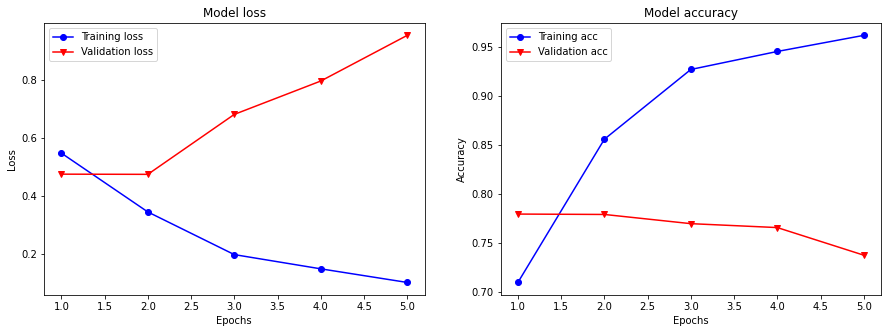

In [52]:
print(f"Keys: {history_1.history.keys()}\n")

# Find epoch with highest validation accuracy
max_val = max(history_1.history['val_accuracy'])
max_index = history_1.history['val_accuracy'].index(max_val)
max_epoc_1 = max_index + 1 # index starts at 0
print(f"Highest val accuracy: EPOC = {max_epoc_1}")

scores_model = {'GRU': 
     {'epoc': max_epoc_1,
      'loss': np.round(history_1.history['loss'][max_index], 3),
      'accuracy': np.round(history_1.history['accuracy'][max_index], 3),
      'val_loss': np.round(history_1.history['val_loss'][max_index], 3),
      'val_acc': np.round(history_1.history['val_accuracy'][max_index], 3)}
    }

print(scores_model)
print(scores_model['GRU'])
print(scores_model['GRU']['val_acc'])

plot_loss_acc(history_1.history)

# Model 2: pretrained embedding

In [53]:
size_train_set = int(len(datasets["train"]) * 0.8)

print(f"Size full set:  {len(datasets['train'])}")
print(f"Size train set: {size_train_set}")
print(f"Size val set:    {len(datasets['train']) - size_train_set}")

train_set_2 = datasets["train"].take(int(20000))
print(f"\nSize train_set_2: {len(train_set_2)}")
train_set_2 = train_set_2.batch(32).prefetch(1)
print(f"Size train_set_2 batched: {len(train_set_2)}")

val_set_2 = datasets["train"].skip(int(20000))
print(f"\nSize val_set_2: {len(val_set_2)}")
val_set_2 = val_set_2.batch(32).prefetch(1)
print(f"Size val_set_2 batched: {len(val_set_2)}")

Size full set:  25000
Size train set: 20000
Size val set:    5000

Size train_set_2: 20000
Size train_set_2 batched: 625

Size val_set_2: 5000
Size val_set_2 batched: 157


`emb_layer`: a tensorflow hub layer; it is a pre-trained embedding that maps a sentence to its embedding vector; it (I) splits the sentences into tokens, (II) embeds each token (word embedding), and (III) combines the word embeddings into a whole embedding (sentence embedding). The shape of the output is (num_examples, embedding_dimension), that is (X_train.shape, 50).

In [54]:
emb_layer = hub.KerasLayer(
    "https://tfhub.dev/google/nnlm-en-dim50/2",
    input_shape=[],  # input shape is a list
    dtype=tf.string,
    output_shape=[50],
    # set "trainable=True" to perform transfer learning (fine-tune the model)
    trainable=True)

model_2 = keras.models.Sequential([
    emb_layer,

    layers.Dense(16, use_bias=False),
    layers.BatchNormalization(),
    layers.Activation(activation="relu"),
    layers.Dropout(0.5),
    
    layers.Dense(1, activation="sigmoid")
])

model_2.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    metrics=["accuracy"]
)

In [55]:
print(model_2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense_1 (Dense)             (None, 16)                800       
                                                                 
 batch_normalization (BatchN  (None, 16)               64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 16)                0         
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                      

In [56]:
history_2 = model_2.fit(
    train_set_2,
    epochs=5,
    # batch_size=32, # alread done above
    validation_data=val_set_2)

Epoch 1/5
625/625 [==============================] - 13s 20ms/step - loss: 0.3975 - accuracy: 0.8278 - val_loss: 0.3078 - val_accuracy: 0.8694
Epoch 2/5
625/625 [==============================] - 13s 20ms/step - loss: 0.1650 - accuracy: 0.9417 - val_loss: 0.4032 - val_accuracy: 0.8544
Epoch 3/5
625/625 [==============================] - 13s 20ms/step - loss: 0.0945 - accuracy: 0.9692 - val_loss: 0.6083 - val_accuracy: 0.8440
Epoch 4/5
625/625 [==============================] - 13s 20ms/step - loss: 0.0686 - accuracy: 0.9754 - val_loss: 0.7559 - val_accuracy: 0.8342
Epoch 5/5
625/625 [==============================] - 13s 21ms/step - loss: 0.0535 - accuracy: 0.9820 - val_loss: 0.9013 - val_accuracy: 0.8290


Highest val accuracy: EPOC = 1
Embedding + GRU =              {'epoc': 1, 'loss': 0.548, 'accuracy': 0.71, 'val_loss': 0.476, 'val_acc': 0.78}
Pretrained Embedding + Dense = {'epoc': 1, 'loss': 0.397, 'accuracy': 0.828, 'val_loss': 0.308, 'val_acc': 0.869}


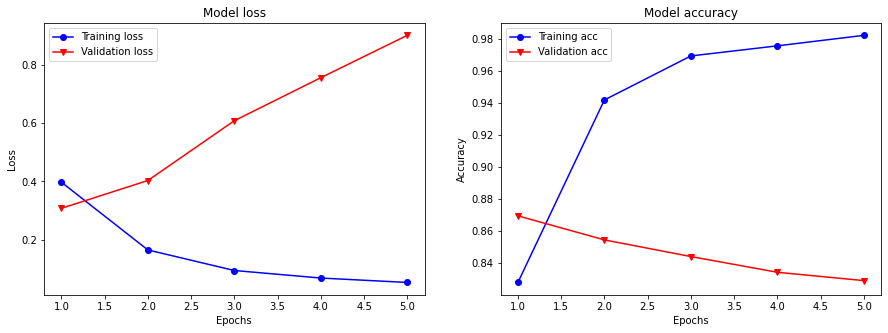

In [57]:
# Find epoch with highest validation accuracy
max_val_2 = max(history_2.history['val_accuracy'])
max_index_2 = history_2.history['val_accuracy'].index(max_val_2)
max_epoc_2 = max_index_2 + 1 # index starts at 0
print(f"Highest val accuracy: EPOC = {max_epoc_2}")

scores_model['pre_emb'] = {
    'epoc': max_epoc_2,
    'loss': np.round(history_2.history['loss'][max_index_2], 3),
    'accuracy': np.round(history_2.history['accuracy'][max_index_2], 3),
    'val_loss': np.round(history_2.history['val_loss'][max_index_2], 3),
    'val_acc': np.round(history_2.history['val_accuracy'][max_index_2], 3)}

print(f"Embedding + GRU =              {scores_model['GRU']}")
print(f"Pretrained Embedding + Dense = {scores_model['pre_emb']}")

# Plot loss and accuracy
plot_loss_acc(history_2.history)

# Model 3: pretrained emb + GRU

In [58]:
emb_layer_2 = hub.KerasLayer(
    "https://tfhub.dev/google/nnlm-en-dim50/2",
    input_shape=[],  # input shape is a list
    dtype=tf.string,
    # set "trainable=True" to perform transfer learning (fine-tune the model)
    trainable=False)

In [59]:
print(f"Shape: {tf.shape(emb_layer_2.weights)}\n")
print(f"Weights of last word:\n{emb_layer_2.weights[0][963811]}")

Shape: [     1 963812     50]

Weights of last word:
[ 0.4463733   0.06268543  0.02524463 -0.03003857 -0.07518507  0.10584744
  0.05190546  0.07918476 -0.00114658 -0.02522112 -0.05618273  0.20218264
 -0.18284753  0.02534474 -0.13071997 -0.1094304  -0.20741123  0.01510983
  0.05321887 -0.17604783 -0.01244334 -0.23229207 -0.15607479  0.00682715
 -0.00777245 -0.1966516   0.03222495  0.08452887 -0.15912555  0.16508932
 -0.00970589  0.14970572 -0.07301918 -0.29117134  0.12118941 -0.17614129
 -0.243724   -0.18572477 -0.11401933  0.00484178  0.13486008  0.00838438
 -0.252614    0.19786541  0.07006849  0.16772746 -0.05321772  0.17416938
 -0.11148718  0.2714855 ]


In [60]:
n_dim_emb = tf.shape(emb_layer_2.weights)[2]
print(f"Number of dimensions: {n_dim_emb}\n")

Number of dimensions: 50



`vocabulary_subset` was created above

In [61]:
print(f"length vocabulary: {len(vocabulary_subset)}\n")

# To create "vocabulary_subset", we only used the 10000 most common words in the vocabolary
vocab_size = 10000

length vocabulary: 10000



In [62]:
for index, word in enumerate(vocabulary_subset[:10]):
    print(index, " -- ", word)

0  --  b'<pad>'
1  --  b'the'
2  --  b'a'
3  --  b'of'
4  --  b'and'
5  --  b'to'
6  --  b'I'
7  --  b'is'
8  --  b'in'
9  --  b'this'


In [63]:
word_index = dict(zip(vocabulary_subset, range(len(vocabulary_subset))))

print(f"<pad>: {word_index[b'<pad>']}")
print(f"the:   {word_index[b'the']}")
print(f"a:     {word_index[b'a']}")
print(f"this:  {word_index[b'this']}")

<pad>: 0
the:   1
a:     2
this:  9


In [64]:
for word, index in list(word_index.items())[:10]:
    print(index, " -- ", word)

0  --  b'<pad>'
1  --  b'the'
2  --  b'a'
3  --  b'of'
4  --  b'and'
5  --  b'to'
6  --  b'I'
7  --  b'is'
8  --  b'in'
9  --  b'this'


In [65]:
emb_1 = emb_layer_2(["<pad>"])
print(f"shape: {emb_1.shape}\n")
print(emb_1)

shape: (1, 50)

tf.Tensor(
[[ 0.08619884  0.07773586  0.09090527 -0.06528513  0.16312574  0.1746562
  -0.29042453  0.34058842 -0.12867717  0.0457645  -0.0541801   0.09583791
  -0.01300897  0.15812047  0.2240742  -0.00496979 -0.06101715  0.04759911
   0.05193571  0.13281709 -0.15151405  0.17609079  0.19989206 -0.19709335
  -0.09719014 -0.2901225   0.11700022  0.09265206 -0.17906703 -0.28486755
   0.27748516 -0.09231462 -0.27417657  0.09934359  0.14005299 -0.21052957
  -0.19520351  0.04808098 -0.04024586 -0.1469216  -0.10068627 -0.07748628
  -0.19279622  0.18174908 -0.16768384 -0.15494153  0.04687274 -0.13806896
  -0.06056129 -0.05874412]], shape=(1, 50), dtype=float32)


In [66]:
word_example = list(word_index.items())[1][0]

print(word_example)

print('\n', emb_layer_2([word_example]))

print('\n', emb_layer_2(["the"]))

b'the'

 tf.Tensor(
[[ 0.11487865  0.20006695  0.4028506   0.17986138 -0.04900441 -0.09742887
  -0.01987137 -0.05182496 -0.02529449  0.13631712  0.00378919  0.21849978
   0.08996052 -0.03973864  0.07005829 -0.20997743 -0.09054149 -0.02437213
  -0.16298744  0.12289404 -0.12056192 -0.1547736  -0.04315764  0.06620021
   0.19259551  0.12415367 -0.1781637   0.03429599 -0.0228256  -0.06757604
  -0.16910565 -0.13549758  0.09297232 -0.32912344 -0.10704424 -0.12266885
   0.05898482 -0.12374956 -0.03804301 -0.34826064 -0.11246426 -0.12397887
  -0.10584528 -0.04936738  0.03223122 -0.01095728 -0.02915668 -0.01456857
  -0.20854506 -0.08049526]], shape=(1, 50), dtype=float32)

 tf.Tensor(
[[ 0.11487865  0.20006695  0.4028506   0.17986138 -0.04900441 -0.09742887
  -0.01987137 -0.05182496 -0.02529449  0.13631712  0.00378919  0.21849978
   0.08996052 -0.03973864  0.07005829 -0.20997743 -0.09054149 -0.02437213
  -0.16298744  0.12289404 -0.12056192 -0.1547736  -0.04315764  0.06620021
   0.19259551  0.124

In [67]:
# The embedding matrix is a matrix of shape:
# (length of the vocabolary, number of embedding dimensions)
# Each row contains the N-dimensional vector (N = number of embedding 
# dimensions) for the word of index corresponding to the row index.
embedding_matrix = np.zeros((vocab_size, n_dim_emb))

for word, index in word_index.items():
    if index < vocab_size:
        embedding_vector = emb_layer_2([word])
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [68]:
print(f"Shape = {embedding_matrix.shape}")

this_word = b'the'

print(f"\nword: {this_word}\nindex: {word_index[this_word]}")

# The 2 following vectors MUST be identical!

print(f"\nVector for 'the' in pretrained layer:\n{emb_layer_2(['the'])}")

print(f"\nRow 1 in embedding matrix:\n{embedding_matrix[1]}")

Shape = (10000, 50)

word: b'the'
index: 1

Vector for 'the' in pretrained layer:
[[ 0.11487865  0.20006695  0.4028506   0.17986138 -0.04900441 -0.09742887
  -0.01987137 -0.05182496 -0.02529449  0.13631712  0.00378919  0.21849978
   0.08996052 -0.03973864  0.07005829 -0.20997743 -0.09054149 -0.02437213
  -0.16298744  0.12289404 -0.12056192 -0.1547736  -0.04315764  0.06620021
   0.19259551  0.12415367 -0.1781637   0.03429599 -0.0228256  -0.06757604
  -0.16910565 -0.13549758  0.09297232 -0.32912344 -0.10704424 -0.12266885
   0.05898482 -0.12374956 -0.03804301 -0.34826064 -0.11246426 -0.12397887
  -0.10584528 -0.04936738  0.03223122 -0.01095728 -0.02915668 -0.01456857
  -0.20854506 -0.08049526]]

Row 1 in embedding matrix:
[ 0.11487865  0.20006695  0.4028506   0.17986138 -0.04900441 -0.09742887
 -0.01987137 -0.05182496 -0.02529449  0.13631712  0.00378919  0.21849978
  0.08996052 -0.03973864  0.07005829 -0.20997743 -0.09054149 -0.02437213
 -0.16298744  0.12289404 -0.12056192 -0.15477359 -0

In [69]:
# Number of dimentions in the embedding
num_word_IDs = vocab_size + num_oov_buckets

model_3 = keras.models.Sequential([
    layers.Embedding(input_dim=vocab_size,
                     output_dim=n_dim_emb,
                     # input_shape=[None]
                     embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                     trainable=True, # trainable=False,
                     mask_zero=True),
    layers.GRU(128, return_sequences=True),
    layers.GRU(128),
    layers.Dense(1, activation="sigmoid")
])

model_3.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

In [70]:
print(model_3.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 50)          500000    
                                                                 
 gru_2 (GRU)                 (None, None, 128)         69120     
                                                                 
 gru_3 (GRU)                 (None, 128)               99072     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 668,321
Trainable params: 668,321
Non-trainable params: 0
_________________________________________________________________
None


In [71]:
history_3 = model_3.fit(
    train_set,
    epochs=5,
    # batch_size=32, # alread done above
    validation_data=val_set)

Epoch 1/5
625/625 [==============================] - 16s 18ms/step - loss: 0.5496 - accuracy: 0.7115 - val_loss: 0.4603 - val_accuracy: 0.7872
Epoch 2/5
625/625 [==============================] - 10s 16ms/step - loss: 0.3782 - accuracy: 0.8376 - val_loss: 0.4484 - val_accuracy: 0.7928
Epoch 3/5
625/625 [==============================] - 10s 16ms/step - loss: 0.2812 - accuracy: 0.8880 - val_loss: 0.4829 - val_accuracy: 0.7846
Epoch 4/5
625/625 [==============================] - 10s 16ms/step - loss: 0.2010 - accuracy: 0.9280 - val_loss: 0.5806 - val_accuracy: 0.7590
Epoch 5/5
625/625 [==============================] - 10s 16ms/step - loss: 0.1555 - accuracy: 0.9432 - val_loss: 0.6803 - val_accuracy: 0.7644


Highest val accuracy: EPOC = 2
Embedding + GRU =              {'epoc': 1, 'loss': 0.548, 'accuracy': 0.71, 'val_loss': 0.476, 'val_acc': 0.78}
Pretrained Embedding + Dense = {'epoc': 1, 'loss': 0.397, 'accuracy': 0.828, 'val_loss': 0.308, 'val_acc': 0.869}
Pretrained Embedding + GRU =   {'epoc': 2, 'loss': 0.378, 'accuracy': 0.838, 'val_loss': 0.448, 'val_acc': 0.793}


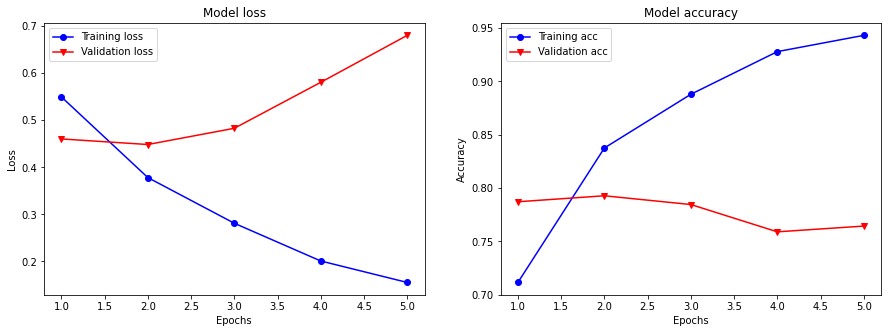

In [72]:
# Find epoch with highest validation accuracy
max_val_3 = max(history_3.history['val_accuracy'])
max_index_3 = history_3.history['val_accuracy'].index(max_val_3)
max_epoc_3 = max_index_3 + 1 # index starts at 0
print(f"Highest val accuracy: EPOC = {max_epoc_3}")

scores_model['pre_emb_GRU'] = {
    'epoc': max_epoc_3,
    'loss': np.round(history_3.history['loss'][max_index_3], 3),
    'accuracy': np.round(history_3.history['accuracy'][max_index_3], 3),
    'val_loss': np.round(history_3.history['val_loss'][max_index_3], 3),
    'val_acc': np.round(history_3.history['val_accuracy'][max_index_3], 3)}

print(f"Embedding + GRU =              {scores_model['GRU']}")
print(f"Pretrained Embedding + Dense = {scores_model['pre_emb']}")
print(f"Pretrained Embedding + GRU =   {scores_model['pre_emb_GRU']}")

# Plot loss and accuracy
plot_loss_acc(history_3.history)

# Retrain best model

In [73]:
# Prepare data for retraining model 2
test_set_2_r = datasets['train'].batch(32).prefetch(1)

In [74]:
# Retrain model 2

emb_layer = hub.KerasLayer(
    "https://tfhub.dev/google/nnlm-en-dim50/2",
    input_shape=[],  # input shape is a list
    dtype=tf.string,
    output_shape=[50],
    # set "trainable=True" to perform transfer learning (fine-tune the model)
    trainable=True)

model_2_r = keras.models.Sequential([
    emb_layer,

    layers.Dense(16, use_bias=False),
    layers.BatchNormalization(),
    layers.Activation(activation="relu"),
    layers.Dropout(0.5),
    
    layers.Dense(1, activation="sigmoid")
])

model_2_r.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    metrics=["accuracy"]
)

In [75]:
print(model_2_r.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 50)                48190600  
                                                                 
 dense_4 (Dense)             (None, 16)                800       
                                                                 
 batch_normalization_1 (Batc  (None, 16)               64        
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 16)                0         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                      

In [76]:
history_2_r = model_2_r.fit(
    test_set_2_r,
    epochs=1,
    # batch_size=32, # alread done above
    )

782/782 [==============================] - 16s 20ms/step - loss: 0.3841 - accuracy: 0.8358


In [77]:
print(f"""Loss = {np.round(history_2_r.history['loss'][-1], 3)}
Accuracy': {np.round(history_2_r.history['accuracy'][-1], 3)}""")


Loss = 0.384
Accuracy': 0.836


# Test accuracy

In [78]:
for x, y in datasets["test"].batch(2).take(1):
    for review, label in zip(x, y):
        print(review.numpy().decode("utf-8"))
        print(f"Label: {label.numpy()}")
        print("="*50)

There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come.
Label: 1
A blackly comic tale of a down-trodden priest, Naza

In [79]:
print(f"num test examples = {info.splits['test'].num_examples}")
print(f"len(datasets['test']) = {len(datasets['test'])}")

num test examples = 25000
len(datasets['test']) = 25000


In [80]:
# Prepare the test set for model 2
test_set_2 = datasets['test'].batch(32).prefetch(1)

print(test_set_2)
print(train_set_2)

<PrefetchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int64)>
<PrefetchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int64)>


In [81]:
# Evaluate model 2 retrained
m2r_test = model_2_r.evaluate(
    test_set_2,
    # batch_size=32, # alread done above
    verbose=0)

In [82]:
print(f"""Loss = {np.round(m2r_test[0], 3)}
Accuracy': {np.round(m2r_test[1], 3)}""")

Loss = 0.327
Accuracy': 0.861


**TEST ACCURACY** of model_2 (Pretrained Embedding + Dense): ~0.861